In [451]:
import pandas as pd
import numpy as np

import re

from matplotlib import colors
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import geopandas as gpd
import folium

from shapely.geometry import polygon, multipolygon, Point

import mapclassify as mc
import libpysal as lp

import esda # Morans
from esda.getisord import G, G_Local

from foursquare import fetch_venue_categories

In [363]:
city_bounds_df = gpd.read_file('data/foursquare_gridsearch/Bangkok.geojson') # (f'data/{trimmed_city_name}_grid.geojson')
city_bounds_df

,geometry
0,"POLYGON ((100.32788 13.80418, 100.32895 13.801..."


In [5]:
def get_primary_bounds(geojson_df):
    for g in geojson_df['geometry']:
        if g and type(g) in (polygon.Polygon, multipolygon.MultiPolygon):
            return g
    return None

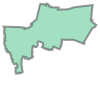

In [364]:
city_bounds = get_primary_bounds(city_bounds_df)
city_bounds

In [287]:
def get_coffee_spots(v):
    ven = v['Venue']
    cat = v['Venue Category']
    
    return re.match(r"coffee", str(ven).lower()) is not None\
        or re.match(r"cafe$", str(ven).lower()) is not None\
        or re.match(r"coffee", str(cat).lower()) is not None\
        or re.match(r"cafe$", str(cat).lower()) is not None

def get_barbershops(v):
    ven = v['Venue']
    cat = v['Venue Category']
    
    return re.match(r"barber", str(ven).lower()) is not None\
        or re.match(r"hair", str(ven).lower()) is not None\
        or re.match(r"salon", str(ven).lower()) is not None\
        or re.match(r"barber", str(cat).lower()) is not None\
        or re.match(r"hair", str(cat).lower()) is not None\
        or re.match(r"salon", str(cat).lower()) is not None

# def get_restaurants(v):
#     ven = v['Venue']
#     cat = v['Venue Category']
#     # 'food', 'burger', 'juice bar', 'breakfast', 'brunch', 'lunch', 'dinner', 'hot dog', 'taco'
#     return re.match(r"restaurant", str(ven).lower()) is not None\
#         or re.match(r"diner", str(ven).lower()) is not None\
#         or re.match(r"pizza", str(ven).lower()) is not None\
#         or re.match(r"barber", str(cat).lower()) is not None\
#         or re.match(r"hair", str(cat).lower()) is not None\
#         or re.match(r"salon", str(cat).lower()) is not None

In [365]:
venues_df = pd.read_csv('data/foursquare_gridsearch/Bangkok_grid_venues.csv', index_col=0)\
                    .drop(['City', 'Grid Item'], axis=1)\
                    .reset_index(drop=True)
venues_df

,Venue,Venue Category,Venue Latitude,Venue Longitude
0,Steak Today (สเต็กทูเดย์),Steakhouse,13.648968,100.346158
1,Nuannoradit Wittayakhom Rachamangkhalaphisek S...,High School,13.646133,100.346415
2,เตี๋ยวหมูกรอบต้มยำ,NaN,13.649340,100.349163
3,ร้านไก่ทอด,NaN,13.649114,100.349314
4,P.S.C Bangbon,NaN,13.647186,100.346601
...,...,...,...,...
62447,วัดใหม่เจริญราษฎร์,Temple,13.888279,100.906626
62448,ศูนย์ 44 สาขาวัดใหม่เจริญราษฏร์,Doctor's Office,13.887870,100.905196
62449,ที่ดินเค้า,NaN,13.890179,100.905271
62450,วัดป่าวิศรุตรัตนาราม,Buddhist Temple,13.925631,100.901099


In [267]:
categories_df = pd.DataFrame(fetch_venue_categories())
categories_df

url https://api.foursquare.com/v2/venues/categories?client_id=5YWYDD1OYF3I3QYJMUFJX3O1UDV5MU4NCBI30FYK4YHMGWQ4&client_secret=LFUHV1IDE4KESRNAONHO1YX42CCC5GICZ112WKKL3HHJ2PGU&v=20180605
{'categories': [{'id': '4d4b7104d754a06370d81259', 'name': 'Arts & Entertainment', 'pluralName': 'Arts & Entertainment', 'shortName': 'Arts & Entertainment', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/default_', 'suffix': '.png'}, 'categories': [{'id': '56aa371be4b08b9a8d5734db', 'name': 'Amphitheater', 'pluralName': 'Amphitheaters', 'shortName': 'Amphitheater', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/default_', 'suffix': '.png'}, 'categories': []}, {'id': '4fceea171983d5d06c3e9823', 'name': 'Aquarium', 'pluralName': 'Aquariums', 'shortName': 'Aquarium', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/aquarium_', 'suffix': '.png'}, 'categories': []}, {'id': '4bf58dd8d48988d1e1931735', 'name': 'Arcade', 

,name,category
0,Amphitheater,Arts & Entertainment
1,Aquarium,Arts & Entertainment
2,Arcade,Arts & Entertainment
3,Art Gallery,Arts & Entertainment
4,Bowling Alley,Arts & Entertainment
...,...,...
926,Train Station,Travel & Transport
927,Tram Station,Travel & Transport
928,Transportation Service,Travel & Transport
929,Travel Lounge,Travel & Transport


In [340]:
food_venues_list = list(categories_df[categories_df.category=='Food'].name)

In [366]:
food_venues_df = venues_df[venues_df['Venue Category'].isin(food_venues_list)]
food_venues_df

,Venue,Venue Category,Venue Latitude,Venue Longitude
0,Steak Today (สเต็กทูเดย์),Steakhouse,13.648968,100.346158
7,ร้านต้มเลือดหมู บางบอน5,Thai Restaurant,13.649328,100.349453
8,ก๋วยเตี๋ยวหมูตุ๋นต้มยำ บางบอน5,Noodle House,13.649365,100.349204
9,เตี๋ยวหมูมะนาวหมูกรอบ,Noodle House,13.649384,100.349233
10,ร้านตำแซบ,Thai Restaurant,13.649388,100.348099
...,...,...,...,...
62380,ร้านต้อย (หนองจอก),Thai Restaurant,13.911211,100.863343
62419,เคียงนากาแฟ,Coffee Shop,13.820087,100.928730
62422,ฟาตีฮะห์ ก๋วยเตี๋ยวไก่ รสเด็ด,Halal Restaurant,13.825872,100.917922
62424,ร้านก๋วยเตี๋ยวกะทิ,Noodle House,13.812477,100.929412


In [367]:
food_venues_df['geometry'] = food_venues_df.apply(lambda v: Point(v['Venue Longitude'],v['Venue Latitude']), axis=1)
food_venues_df.drop(['Venue Longitude','Venue Latitude'], axis=1,inplace=True)
food_venues_df

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Venue,Venue Category,geometry
0,Steak Today (สเต็กทูเดย์),Steakhouse,POINT (100.3461575241123 13.64896760596423)
7,ร้านต้มเลือดหมู บางบอน5,Thai Restaurant,POINT (100.349453 13.649328)
8,ก๋วยเตี๋ยวหมูตุ๋นต้มยำ บางบอน5,Noodle House,POINT (100.349204 13.649365)
9,เตี๋ยวหมูมะนาวหมูกรอบ,Noodle House,POINT (100.3492330183015 13.64938428200859)
10,ร้านตำแซบ,Thai Restaurant,POINT (100.348099 13.649388)
...,...,...,...
62380,ร้านต้อย (หนองจอก),Thai Restaurant,POINT (100.8633425443465 13.91121064680887)
62419,เคียงนากาแฟ,Coffee Shop,POINT (100.9287300254378 13.82008701340328)
62422,ฟาตีฮะห์ ก๋วยเตี๋ยวไก่ รสเด็ด,Halal Restaurant,POINT (100.9179216385562 13.82587159615574)
62424,ร้านก๋วยเตี๋ยวกะทิ,Noodle House,POINT (100.9294121218199 13.81247687226369)


In [368]:
food_venues_gdf = gpd.GeoDataFrame(food_venues_df, crs={'init': 'epsg:4326'})
food_venues_gdf

,Venue,Venue Category,geometry
0,Steak Today (สเต็กทูเดย์),Steakhouse,POINT (100.34616 13.64897)
7,ร้านต้มเลือดหมู บางบอน5,Thai Restaurant,POINT (100.34945 13.64933)
8,ก๋วยเตี๋ยวหมูตุ๋นต้มยำ บางบอน5,Noodle House,POINT (100.34920 13.64936)
9,เตี๋ยวหมูมะนาวหมูกรอบ,Noodle House,POINT (100.34923 13.64938)
10,ร้านตำแซบ,Thai Restaurant,POINT (100.34810 13.64939)
...,...,...,...
62380,ร้านต้อย (หนองจอก),Thai Restaurant,POINT (100.86334 13.91121)
62419,เคียงนากาแฟ,Coffee Shop,POINT (100.92873 13.82009)
62422,ฟาตีฮะห์ ก๋วยเตี๋ยวไก่ รสเด็ด,Halal Restaurant,POINT (100.91792 13.82587)
62424,ร้านก๋วยเตี๋ยวกะทิ,Noodle House,POINT (100.92941 13.81248)


In [369]:
food_venues_gdf.to_file("data/Bangkok_food.geojson", driver='GeoJSON')

In [370]:
city_neighborhoods_gdf = gpd.read_file('data/Bangkok_neighbourhoods.json')
# Only include neighborhoods which were queried
city_neighborhoods_gdf = city_neighborhoods_gdf[city_neighborhoods_gdf.geometry.within(city_bounds)==True]
city_neighborhoods_gdf

,id,ID_0,ISO,NAME_0,ID_1,NAME_1,ID_2,NAME_2,VARNAME_2,NL_NAME_2,HASC_2,CC_2,TYPE_2,ENGTYPE_2,VALIDFR_2,VALIDTO_2,REMARKS_2,Shape_Leng,Shape_Area,geometry
8,adm2_greaterBK_hD4.6,218,THA,Thailand,2823,Bangkok Metropolis,32372,Suan Luang,,???????,TH.BM.SL,1034,Khet,District,Unknown,Present,,0.219939,0.002017,"MULTIPOLYGON (((100.64291 13.75002, 100.64362 ..."
10,adm2_greaterBK_hD4.8,218,THA,Thailand,2823,Bangkok Metropolis,32367,Ratchathewi,Rat Thewi,???????,TH.BM.RT,1037,Khet,District,Unknown,Present,,0.118140,0.000582,"MULTIPOLYGON (((100.54492 13.76350, 100.54534 ..."
11,adm2_greaterBK_hD4.28,218,THA,Thailand,2823,Bangkok Metropolis,32345,Din Dang,Din Daeng,??????,TH.BM.DI,1026,Khet,District,Unknown,Present,,0.128944,0.000691,"MULTIPOLYGON (((100.57342 13.80271, 100.57297 ..."
13,adm2_greaterBK_hD4.10,218,THA,Thailand,2823,Bangkok Metropolis,32369,Samphantawong,,???????????,TH.BM.SA,1013,Khet,District,Unknown,Present,,0.055845,0.000148,"MULTIPOLYGON (((100.51156 13.73253, 100.51098 ..."
14,adm2_greaterBK_hD4.24,218,THA,Thailand,2823,Bangkok Metropolis,32341,Bangkok Yai,,??????????,TH.BM.BY,1016,Khet,District,Unknown,Present,,0.094922,0.000529,"MULTIPOLYGON (((100.48710 13.74964, 100.48759 ..."
15,adm2_greaterBK_hD4.11,218,THA,Thailand,2823,Bangkok Metropolis,32370,Saphan Sung,,????????,TH.BM.SS,1044,Khet,District,Unknown,Present,,0.231558,0.002323,"MULTIPOLYGON (((100.70969 13.79216, 100.71050 ..."
16,adm2_greaterBK_hD4.12,218,THA,Thailand,2823,Bangkok Metropolis,32371,Sathorn,Saton,????,TH.BM.ST,1028,Khet,District,Unknown,Present,,0.133639,0.000607,"MULTIPOLYGON (((100.55206 13.72383, 100.55267 ..."
18,adm2_greaterBK_hD4.14,218,THA,Thailand,2823,Bangkok Metropolis,32331,Bang Kapi,,??????,TH.BM.KP,1006,Khet,District,Unknown,Present,,0.312211,0.002324,"MULTIPOLYGON (((100.62761 13.82247, 100.62820 ..."
20,adm2_greaterBK_hD4.15,218,THA,Thailand,2823,Bangkok Metropolis,32332,Bang Khae,,?????,TH.BM.KA,1040,Khet,District,Unknown,Present,,0.272070,0.004073,"MULTIPOLYGON (((100.36264 13.75709, 100.36314 ..."
21,adm2_greaterBK_hD4.25,218,THA,Thailand,2823,Bangkok Metropolis,32342,Bung Kum,Bueng Kum,???????,TH.BM.BK,1027,Khet,District,Unknown,Present,,0.220508,0.001974,"MULTIPOLYGON (((100.64599 13.85011, 100.64787 ..."


In [376]:
# city_neighborhoods_gdf = city_neighborhoods_gdf[['NAME_2', 'geometry']]
city_neighborhoods_gdf.columns = ['neighbourhood', 'geometry']
city_neighborhoods_gdf

,neighbourhood,geometry
8,Suan Luang,"MULTIPOLYGON (((100.64291 13.75002, 100.64362 ..."
10,Ratchathewi,"MULTIPOLYGON (((100.54492 13.76350, 100.54534 ..."
11,Din Dang,"MULTIPOLYGON (((100.57342 13.80271, 100.57297 ..."
13,Samphantawong,"MULTIPOLYGON (((100.51156 13.73253, 100.51098 ..."
14,Bangkok Yai,"MULTIPOLYGON (((100.48710 13.74964, 100.48759 ..."
15,Saphan Sung,"MULTIPOLYGON (((100.70969 13.79216, 100.71050 ..."
16,Sathorn,"MULTIPOLYGON (((100.55206 13.72383, 100.55267 ..."
18,Bang Kapi,"MULTIPOLYGON (((100.62761 13.82247, 100.62820 ..."
20,Bang Khae,"MULTIPOLYGON (((100.36264 13.75709, 100.36314 ..."
21,Bung Kum,"MULTIPOLYGON (((100.64599 13.85011, 100.64787 ..."


In [377]:
venue_density_df =\
    gpd.sjoin(food_venues_gdf,city_neighborhoods_gdf,how='right',op='within')\
        .groupby('neighbourhood')\
        .agg({'geometry': 'first', 'Venue': 'count'})

venue_density_df =\
    gpd.GeoDataFrame(venue_density_df, crs={'init': 'epsg:4326'})

venue_density_df['area_sqkm'] =\
    venue_density_df.apply(lambda n: n.geometry.area/10**6, axis=1)
venue_density_df['density'] =\
    venue_density_df['Venue']/venue_density_df['area_sqkm']

venue_density_df.reset_index(inplace=True)
venue_density_df

,neighbourhood,geometry,Venue,area_sqkm,density
0,Bang Kapi,"MULTIPOLYGON (((100.62761 13.82247, 100.62820 ...",672,2.323908e-09,2.891681e+11
1,Bang Khae,"MULTIPOLYGON (((100.36264 13.75709, 100.36314 ...",603,4.072523e-09,1.480655e+11
2,Bang Khen,"MULTIPOLYGON (((100.61126 13.88885, 100.61171 ...",366,3.436258e-09,1.065112e+11
3,Bang Kho Laem,"MULTIPOLYGON (((100.52071 13.70601, 100.52115 ...",313,7.189977e-10,4.353282e+11
4,Bang Rak,"MULTIPOLYGON (((100.52193 13.72298, 100.51620 ...",256,3.449174e-10,7.422066e+11
5,Bangkok Yai,"MULTIPOLYGON (((100.48710 13.74964, 100.48759 ...",47,5.286019e-10,8.891380e+10
6,Bung Kum,"MULTIPOLYGON (((100.64599 13.85011, 100.64787 ...",603,1.974069e-09,3.054605e+11
7,Chatuchak,"MULTIPOLYGON (((100.58527 13.86102, 100.58582 ...",1093,2.722847e-09,4.014181e+11
8,Chom Thong,"MULTIPOLYGON (((100.46914 13.71349, 100.46981 ...",237,1.975178e-09,1.199892e+11
9,Din Dang,"MULTIPOLYGON (((100.57342 13.80271, 100.57297 ...",545,6.905501e-10,7.892259e+11


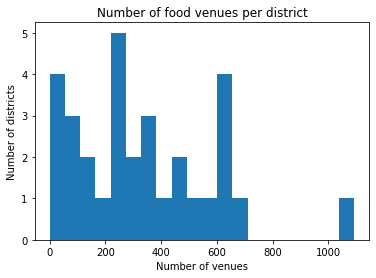

In [515]:
venue_density_df.Venue.plot(kind='hist', bins=20)
plt.title('Number of food venues per district')
plt.xlabel('Number of venues')
plt.ylabel('Number of districts')
plt.show()

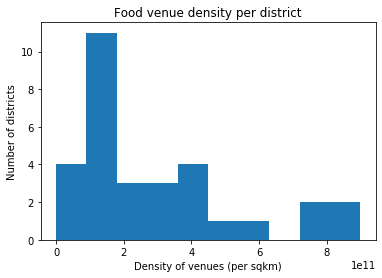

In [517]:
venue_density_df.density.plot(kind='hist')
plt.title('Food venue density per district')
plt.xlabel('Density of venues (per sqkm)')
plt.ylabel('Number of districts')
plt.show()

In [381]:
saturated_neigh_df = venue_density_df[venue_density_df.Venue > 0]
len(saturated_neigh_df)

30

In [386]:
city_map = folium.Map(
    location=(city_bounds.centroid.y,city_bounds.centroid.x),
    zoom_start=10,
    tiles='cartodbpositron' #'Stamen Toner'
)

# Plot grid query region
# folium.GeoJson(
#     city_bounds, #'data/foursquare_gridsearch/NewYorkCity_grid.geojson',
#     name='geojson',
#     color='red'
# ).add_to(city_map)

# Plot 
# folium.GeoJson(
#     neighborhood_venue_counts_df, #city_neighborhoods_df, #'data/NewYorkCity_neighbourhoods.geojson',
#     name='geojson'
# ).add_to(city_map)

# [folium.CircleMarker(
#     [row['Venue Latitude'], row['Venue Longitude']],
#     radius=1,
#     color='blue',
#     fill=True,
#     fill_color='#3186cc',
#     fill_opacity=0.5
# ).add_to(city_map) for i,row in barbershop_df.iterrows()]

#     fill_color='YlGn',
#     fill_opacity=0.7,
#     line_opacity=0.2,

folium.Choropleth(
    geo_data=city_neighborhoods_gdf,
    name='choropleth',
    data=saturated_neigh_df,
    columns=['neighbourhood','density'],
    key_on='feature.properties.neighbourhood',
    fill_color='Purples',
    bins=5,
    legend_name='Food Venues (per sqkm)'
).add_to(city_map)

city_map

In [387]:
# Global autocorrelation test - is the distribution of barbershops random?

wq =  lp.weights.Queen.from_dataframe(saturated_neigh_df)
wq.transform = 'r'

In [388]:
# Compute spatial lag - the weighted average of barbershop density per neighborhood

y = saturated_neigh_df['density']
ylag = lp.weights.lag_spatial(wq, y)
ylag[0:5]

array([2.23118772e+11, 1.64804248e+11, 2.54034575e+11, 2.90041619e+11,
       3.30042002e+11])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


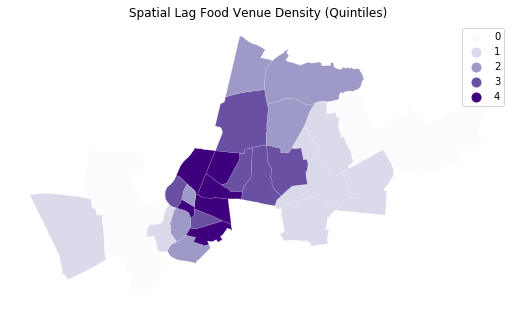

In [389]:
# Plot Food venue density quintiles and spatial lag
ylagq5 = mc.Quantiles(ylag, k=5)

saturated_neigh_df['cl']=pd.Series(ylagq5.yb).astype('category')

f, ax = plt.subplots(1, figsize=(9, 9))
saturated_neigh_df.plot(column='cl', categorical=True, k=5, \
        cmap='Purples', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Spatial Lag Food Venue Density (Quintiles)")

plt.show()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


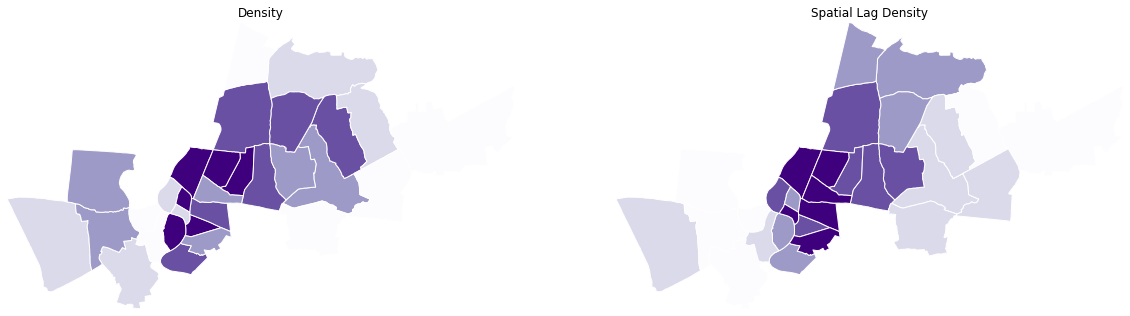

In [390]:
saturated_neigh_df['lag_density'] = ylag #make this _gdf
f,ax = plt.subplots(1,2,figsize=(20,10))

saturated_neigh_df.plot(column='density', ax=ax[0], edgecolor='white',
        scheme="quantiles",  k=5, cmap='Purples')
ax[0].axis(saturated_neigh_df.total_bounds[np.asarray([0,2,1,3])])
ax[0].set_title("Density")

saturated_neigh_df.plot(column='lag_density', ax=ax[1], edgecolor='white',
        scheme='quantiles', cmap='Purples', k=5)
ax[1].axis(saturated_neigh_df.total_bounds[np.asarray([0,2,1,3])])
ax[1].set_title("Spatial Lag Density")
ax[0].axis('off')
ax[1].axis('off')

plt.show()

Text(0.5, 0, "Moran's I")

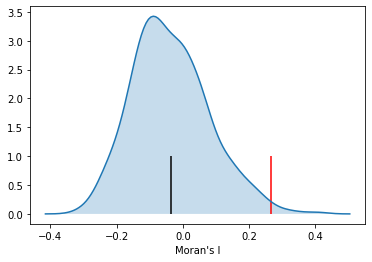

In [391]:
np.random.seed(123)
mi = esda.moran.Moran(y, wq)

sns.kdeplot(mi.sim, shade=True)
plt.vlines(mi.I, 0, 1, color='r')
plt.vlines(mi.EI, 0,1)
plt.xlabel("Moran's I")

In [392]:
# A p-value of 0.05 and less is significant
mi.p_sim

0.011

In [245]:
# Globally, distribution is statistically significant. 
# We reject our null hypothesis that venue distribution is random.

## Local Autocorrelation

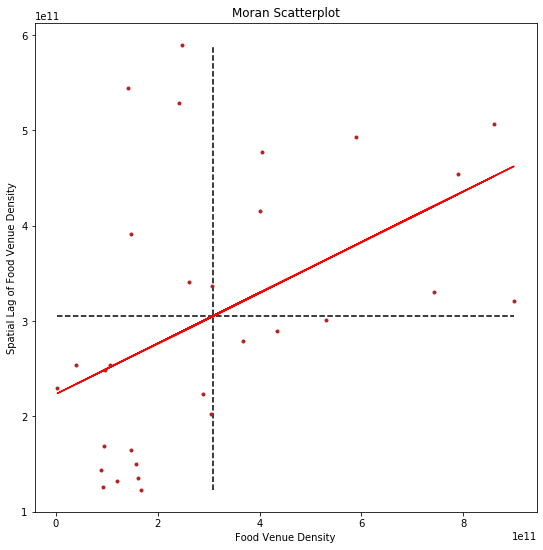

In [393]:
b, a = np.polyfit(y, ylag, 1)
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(y, ylag, '.', color='firebrick')

 # dashed vert at mean of the price
plt.vlines(y.mean(), ylag.min(), ylag.max(), linestyle='--')
 # dashed horizontal at mean of lagged price 
plt.hlines(ylag.mean(), y.min(), y.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(y, a + b*y, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Food Venue Density')
plt.xlabel('Food Venue Density')
plt.show()

In [468]:
li = esda.moran.Moran_Local(y, wq)

In [469]:
# Determine number of statistically-significant hotspots/coldspots
(li.p_sim < 0.05).sum()

8

In [471]:
sig = 1 * (li.p_sim < 0.05)

hotspot = 1 * (sig * li.q==1)
coldspot = 3 * (sig * li.q==3)
doughnut = 2 * (sig * li.q==2)
diamond = 4 * (sig * li.q==4)

spots = hotspot + coldspot + doughnut + diamond
spots

array([0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 3, 1, 0, 0,
       2, 2, 0, 2, 0, 0, 0, 0])

In [472]:
spot_labels = ['0 not significant', '1 hot spot', '2 doughnut', '3 cold spot', '4 diamond']
labels = [spot_labels[i] for i in spots]

In [480]:
li.z_sim

array([ 0.91017954,  0.85661201,  0.58147052, -0.13430315,  0.30962678,
        1.50864037,  1.0105939 ,  1.41701126,  1.06035571,  1.46161691,
        2.01922268, -0.33612646,  1.39522294,  0.04373453,  0.32899965,
       -0.25227196,  1.11054339,  1.88583762,  1.82027286,  2.00615805,
       -0.78756116,  0.34387942, -2.69474985, -2.20232558,  1.42690874,
       -1.88767551,  0.64692888,  1.26756399,  0.73590122, -0.25488631])

In [486]:
# saturated_neigh_df.loc[:,'cluster_category'] = labels
# saturated_neigh_df.loc[:,'p_value'] = li.p_sim
# saturated_neigh_df.loc[:,'z_score'] = li.z_sim
# saturated_neigh_df.loc[:,'cluster_category'] = saturated_neigh_df['cluster_category'].astype('category')
saturated_neigh_df.head()

,neighbourhood,geometry,Venue,area_sqkm,density,cl,lag_density,cluster_category,p_value,z_score
0,Bang Kapi,"MULTIPOLYGON (((100.62761 13.82247, 100.62820 ...",672,2.323908e-09,2.891681e+11,1,2.231188e+11,0 not significant,0.194,0.910180
1,Bang Khae,"MULTIPOLYGON (((100.36264 13.75709, 100.36314 ...",603,4.072523e-09,1.480655e+11,1,1.648042e+11,0 not significant,0.211,0.856612
2,Bang Khen,"MULTIPOLYGON (((100.61126 13.88885, 100.61171 ...",366,3.436258e-09,1.065112e+11,2,2.540346e+11,0 not significant,0.315,0.581471
3,Bang Kho Laem,"MULTIPOLYGON (((100.52071 13.70601, 100.52115 ...",313,7.189977e-10,4.353282e+11,2,2.900416e+11,0 not significant,0.493,-0.134303
4,Bang Rak,"MULTIPOLYGON (((100.52193 13.72298, 100.51620 ...",256,3.449174e-10,7.422066e+11,3,3.300420e+11,0 not significant,0.344,0.309627


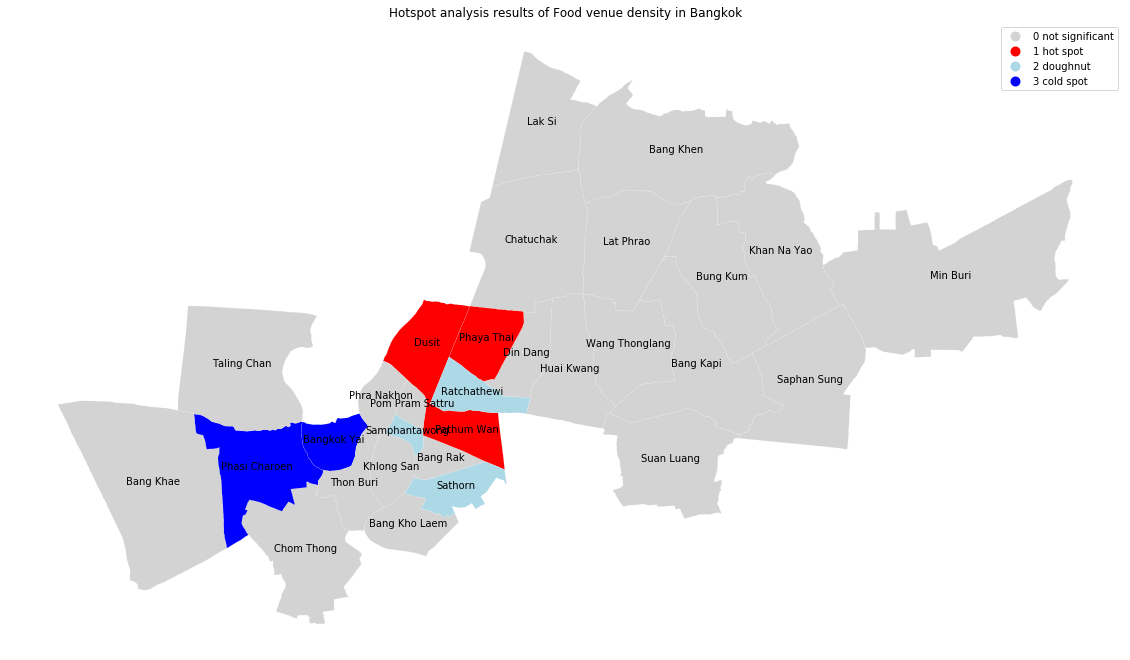

In [485]:
hmap = colors.ListedColormap(['lightgrey', 'red', 'lightblue', 'blue']) # 'pink' for diamonds
f, ax = plt.subplots(1, figsize=(20, 14))

saturated_neigh_df.assign(hotspot_label=labels).plot(column='hotspot_label', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()

saturated_neigh_df.apply(lambda x:\
                         ax.annotate(s=x.neighbourhood, xy=x.geometry.centroid.coords[0], ha='center'),axis=1)

plt.title('Hotspot analysis results of Food venue density in Bangkok')
plt.show()

In [513]:
# Print Doughnut neighbourhoods in order of significance
saturated_neigh_df[saturated_neigh_df.cluster_category=='2 doughnut'][['neighbourhood', 'p_value']]\
    .sort_values('p_value')

,neighbourhood,p_value
22,Ratchathewi,0.009
23,Samphantawong,0.015
25,Sathorn,0.042


In [ ]:
# Print Cold Spot neighbourhoods in order of significance
saturated_neigh_df[saturated_neigh_df.cluster_category=='2 doughnut'][['neighbourhood', 'p_value']]\
    .sort_values('p_value')

In [ ]:
# Moran's I identifies 3 statistically-significant regions as opportunities for food delivery services.
# 

## Global Autocorrelation with Gi*

In [431]:
g = G(y,wq)
g

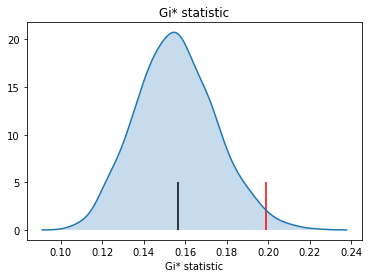

In [450]:
sns.kdeplot(g.sim, shade=True)
plt.vlines(g.G, 0, 5, color='r')
plt.vlines(g.EG, 0, 5)
plt.xlabel("Gi* statistic")
plt.title('Gi* statistic')
plt.show()

In [447]:
# A p-value of 0.05 and less is significant
g.p_sim

0.017

In [433]:
g.z_sim

2.28240619058318

In [ ]:
### Globally, we can reject our null hypothesis that food venue density is random, and look at local autocorrelation

In [448]:
g.p_norm

0.012589722140446291

In [449]:
g.z_sim

2.28240619058318

In [454]:
lg = G_Local(y, wq, transform='R')

In [455]:
lg.Zs

array([-0.3409712 , -0.59741709, -0.245544  , -0.05400966,  0.15673024,
       -0.69662092, -0.41991334,  0.44142691, -0.73421855,  0.69639695,
        0.79686882,  0.11607141, -0.65692622,  0.00290705, -0.25745858,
       -0.10920297, -0.76744984,  0.69036176, -0.76087598,  0.95613326,
        0.31285707,  0.14747159,  1.11802989,  0.93018811, -0.59071688,
        0.8715477 , -0.3620285 , -0.71488582, -0.27039073,  0.12583927])

In [459]:
# Determine number of significant spots
(lg.p_sim <= 0.05).sum()

6